In [1]:
import numpy as np
import pandas as pd
import os
import keras.backend as K

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from pprint import pprint
from collections import defaultdict
import openslide
from openslide import OpenSlide

from glob import glob

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.layers import GlobalMaxPooling2D
from keras.models import load_model

print(keras.__version__)

3.3.3


In [2]:
import random

train_df = pd.read_csv('../input/mayo-clinic-strip-ai/train.csv')
test_df  = pd.read_csv('../input/mayo-clinic-strip-ai/test.csv')

## Data viusalization

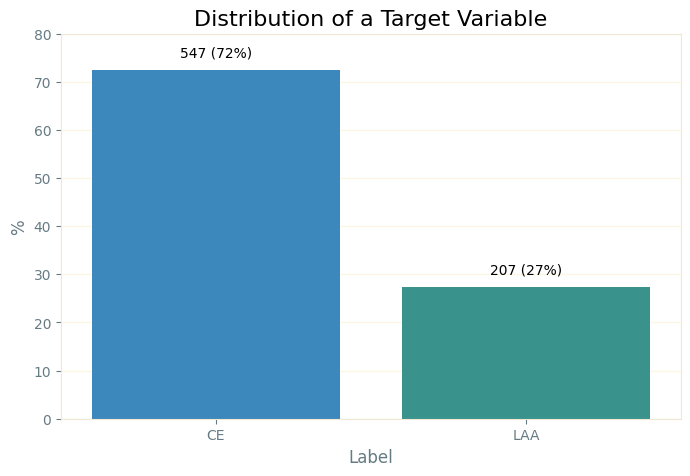

Train Size = 754
Test Size = 4


In [7]:
plt.style.use('Solarize_Light2')
label_percentages = train_df.groupby('label')['label'].count().div(len(train_df)).mul(100)
label_counts = train_df['label'].value_counts()  

plt.figure(figsize=(8, 5), facecolor='white') 
bar_chart = sns.barplot(x=label_percentages.index, y=label_percentages.values)

bar_chart.set_facecolor('white')

plt.title("Distribution of a Target Variable")
plt.ylabel("%")
plt.xlabel("Label")

plt.ylim(0, 80)

for index, patch in enumerate(bar_chart.patches):
    label = label_percentages.index[index]
    count = label_counts[label]
    percentage = int(label_percentages[label])
    bar_chart.annotate(f'{count} ({percentage}%)',
                      (patch.get_x() + patch.get_width() / 2., patch.get_height() + 2),  
                      ha='center', va='bottom', fontsize=10)

plt.show()

print('Train Size = {}'.format(len(train_df)))
print('Test Size = {}'.format(len(test_df)))

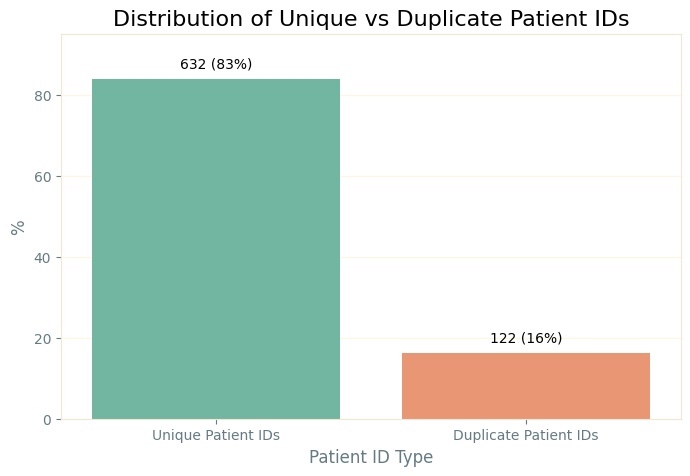

Train Size = 754
Test Size = 4


In [9]:
num_images = train_df.shape[0]
unique_patient_count = len(train_df['patient_id'].unique())

slice_sizes = [unique_patient_count, num_images - unique_patient_count]
slice_labels = ['Unique Patient IDs', 'Duplicate Patient IDs']
percentages = [count / num_images * 100 for count in slice_sizes]

data = pd.DataFrame({
    'Labels': slice_labels,
    'Counts': slice_sizes,
    'Percentages': percentages
})

plt.style.use('Solarize_Light2')

plt.figure(figsize=(8, 5), facecolor='white') 
bar_chart = sns.barplot(x='Labels', y='Percentages', data=data, palette=['#66c2a5', '#fc8d62'])

bar_chart.set_facecolor('white')

plt.title("Distribution of Unique vs Duplicate Patient IDs")
plt.ylabel("%")
plt.xlabel("Patient ID Type")

plt.ylim(0, 95)  

for index, p in enumerate(bar_chart.patches):
    count = data['Counts'][index]
    percentage = int(data['Percentages'][index])
    bar_chart.annotate(f'{count} ({percentage}%)',
                      (p.get_x() + p.get_width() / 2., p.get_height() + 2),
                      ha='center', va='bottom', fontsize=10)

plt.show()

print('Train Size = {}'.format(len(train_df)))
print('Test Size = {}'.format(len(test_df)))

In [10]:
train_image = glob("/kaggle/input/mayo-clinic-strip-ai/train/*")
test_image = glob("/kaggle/input/mayo-clinic-strip-ai/test/*")

print(f"Number of images in a training set: {len(train_image)}")
print(f"Number of images in a training set: {len(test_image)}")

Number of images in a training set: 754
Number of images in a training set: 4


In [11]:
image_metadata = defaultdict(list)

for idx, img_path in enumerate(train_image):
    img_path = train_image[idx]
    slide_obj = OpenSlide(img_path)    
    image_metadata['image_id'].append(img_path[-12:-4])
    image_metadata['width'].append(slide_obj.dimensions[0])
    image_metadata['height'].append(slide_obj.dimensions[1])
    image_metadata['size'].append(round(os.path.getsize(img_path) / 1e6, 2))
    image_metadata['path'].append(img_path)

image_df = pd.DataFrame(image_metadata)
image_df['img_aspect_ratio'] = image_df['width']/image_df['height']
image_df.sort_values(by='image_id', inplace=True)
image_df.reset_index(inplace=True, drop=True)

image_df = image_df.merge(train_df, on='image_id')
image_df.head()

,image_id,width,height,size,path,img_aspect_ratio,center_id,patient_id,image_num,label
0,006388_0,34007,60797,1312.94,/kaggle/input/mayo-clinic-strip-ai/train/00638...,0.559353,11,006388,0,CE
1,008e5c_0,5946,29694,109.57,/kaggle/input/mayo-clinic-strip-ai/train/008e5...,0.200242,11,008e5c,0,CE
2,00c058_0,15255,61801,351.76,/kaggle/input/mayo-clinic-strip-ai/train/00c05...,0.246841,11,00c058,0,LAA
3,01adc5_0,55831,26553,679.17,/kaggle/input/mayo-clinic-strip-ai/train/01adc...,2.102625,11,01adc5,0,LAA
4,026c97_0,10533,8267,61.21,/kaggle/input/mayo-clinic-strip-ai/train/026c9...,1.274102,4,026c97,0,CE


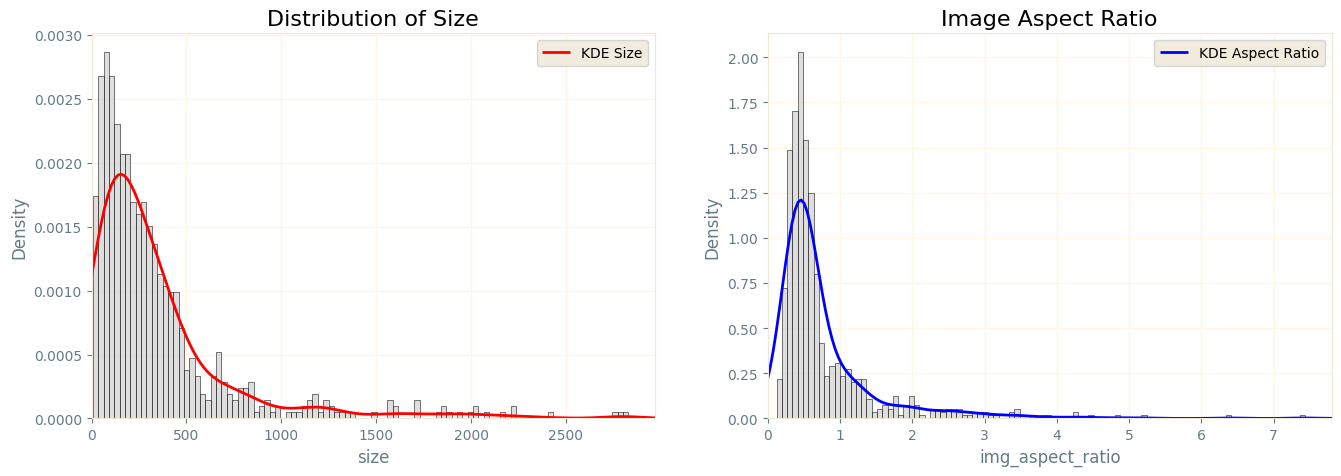

In [12]:
plt.style.use('Solarize_Light2')
fig, ax = plt.subplots(1, 2, figsize=(16, 5), facecolor='white')

sns.histplot(x='size', data=image_df, bins=100, ax=ax[0], stat='density', kde=False, color='lightgray')
ax[0].set_title("Distribution of Size")
ax[0].set_xlim(left=0)

sns.kdeplot(x='size', data=image_df, ax=ax[0], color='red', linewidth=2, label='KDE Size')
ax[0].legend()

sns.histplot(x='img_aspect_ratio', data=image_df, bins=100, ax=ax[1], stat='density', kde=False, color='lightgray')
ax[1].set_title("Image Aspect Ratio")
ax[1].set_xlim(left=0)

sns.kdeplot(x='img_aspect_ratio', data=image_df, ax=ax[1], color='blue', linewidth=2, label='KDE Aspect Ratio')
ax[1].legend()

for a in ax:
    a.set_facecolor('white')

plt.show()

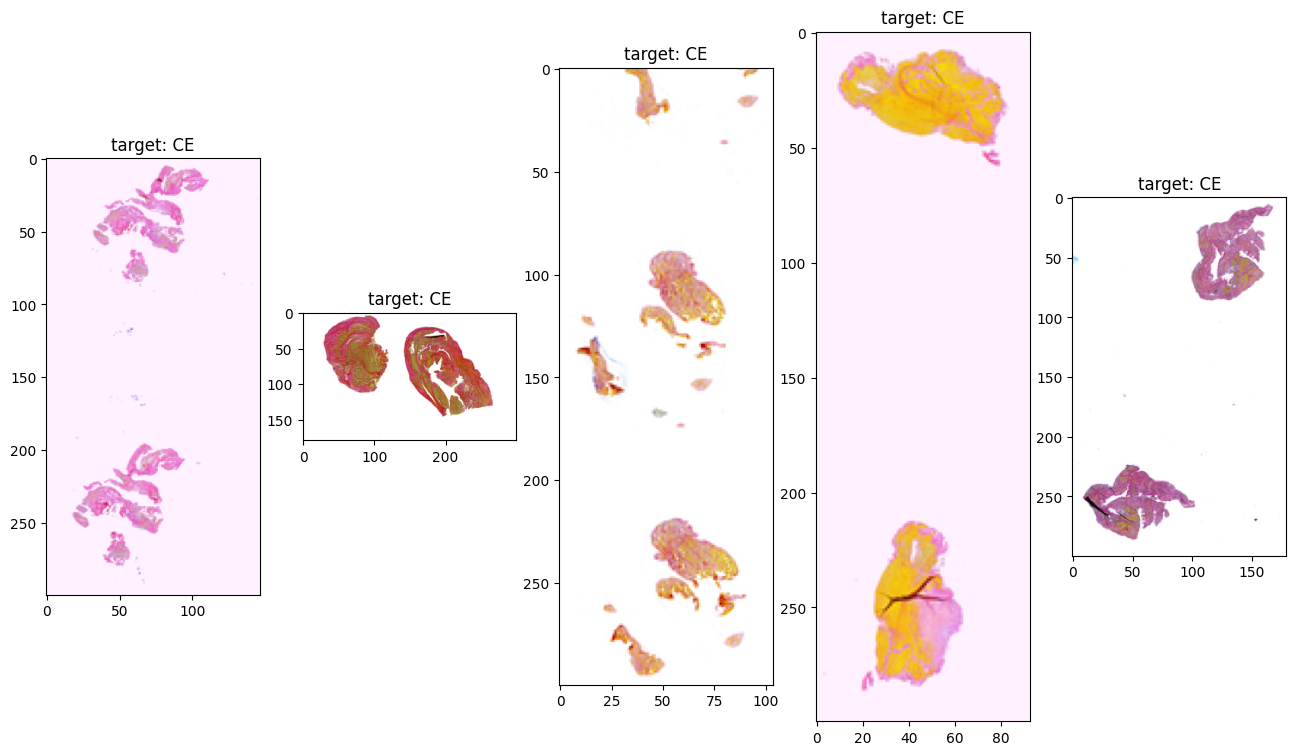

In [13]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None 

ce_image = image_df.loc[image_df['label']=='CE','path']
laa_image = image_df.loc[image_df['label']=='LAA','path']


plt.style.use('default')
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_image
for ax in axes.reshape(-1):
    random_img_path = np.random.choice(ce_image)
    img = Image.open(random_img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: CE")
plt.show()

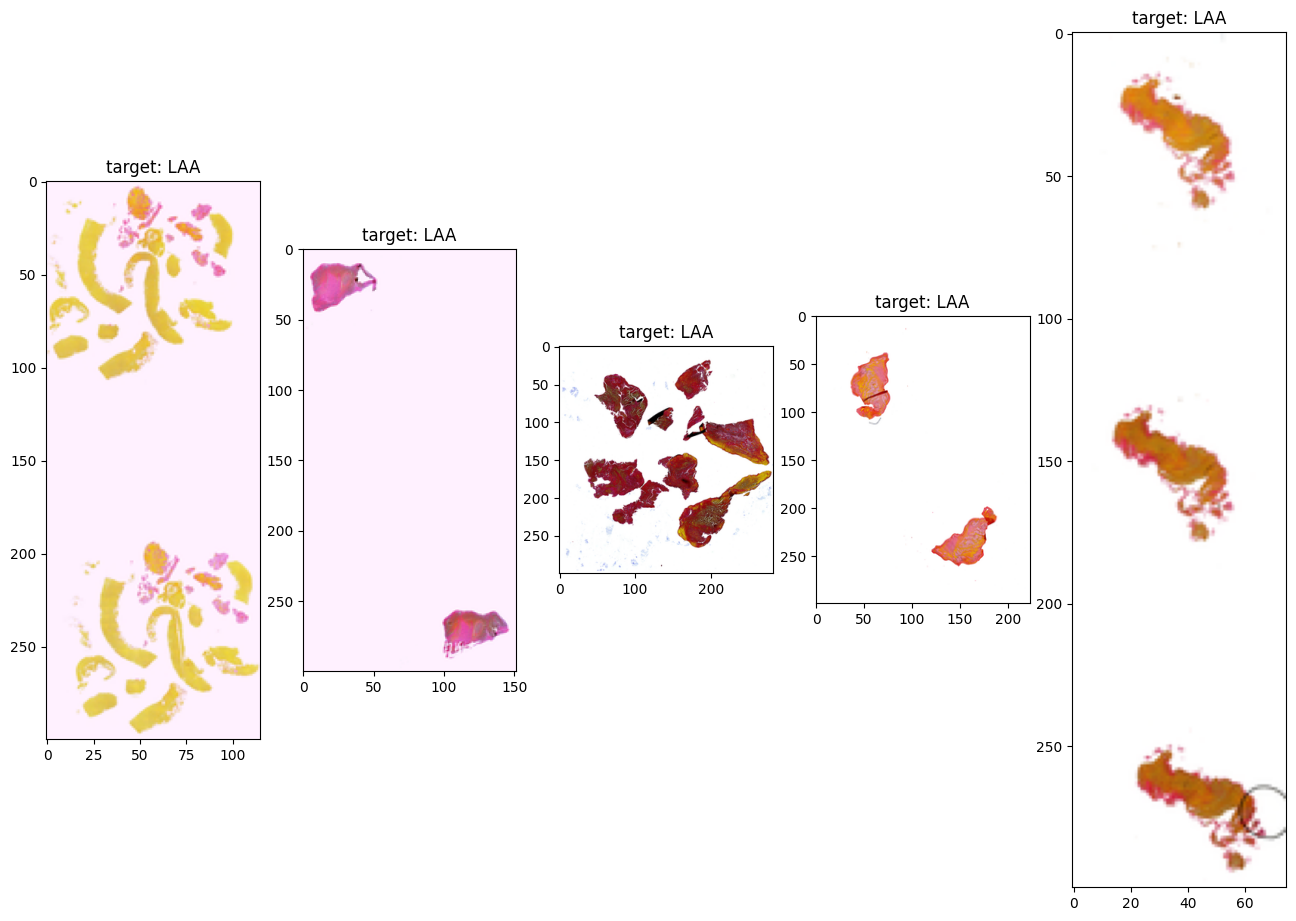

In [8]:
fig, axes = plt.subplots(1,5, figsize=(16,16))
train_image
for ax in axes.reshape(-1):
    img_path = np.random.choice(laa_image)
    img = Image.open(img_path)   
    img.thumbnail((300,300), Image.Resampling.LANCZOS)
    ax.imshow(img), ax.set_title("target: LAA")
plt.show()

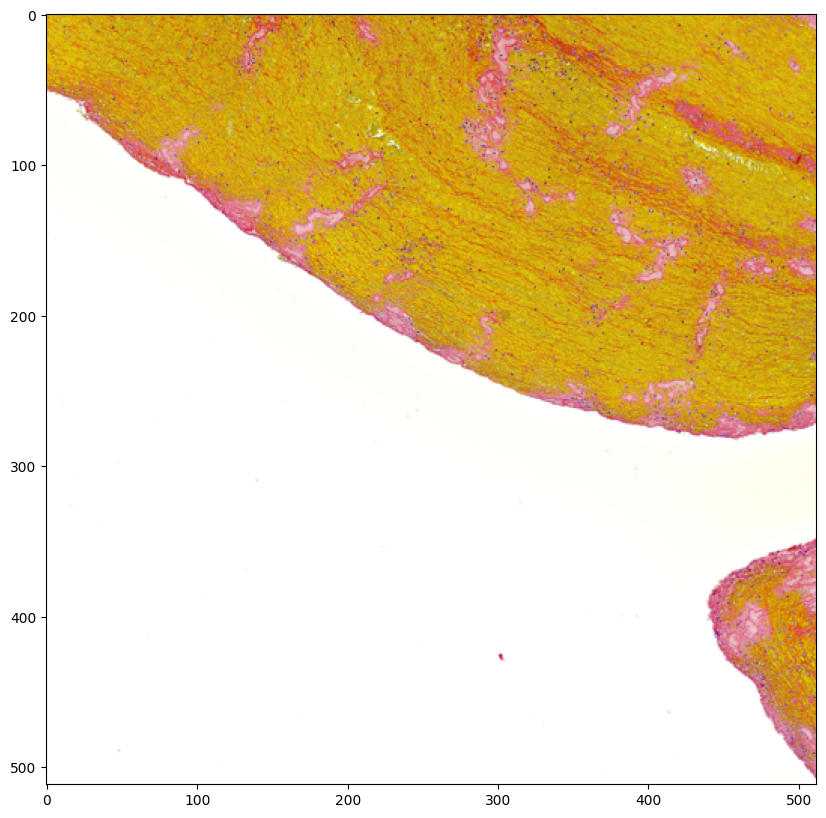

In [36]:
slide = OpenSlide('/kaggle/input/mayo-clinic-strip-ai/train/026c97_0.tif') 

region = (2500, 2000) 
level = 0 
size = (3500, 3500) 

region = slide.read_region(region, level, size)
image = region.resize((512, 512))
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()


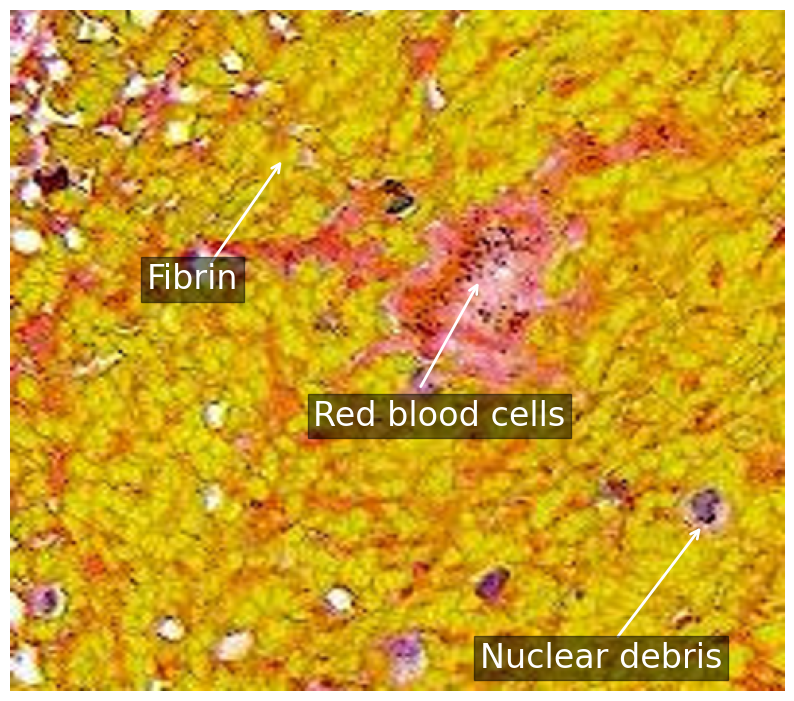

In [38]:
slide_example = OpenSlide('/kaggle/input/mayo-clinic-strip-ai/train/026c97_0.tif')

region = (1400, 1150)
level = 0 
size = (200, 200)

region = slide.read_region(region, level, size)

image = region.resize((512, 450))

plt.figure(figsize=(10, 10))
plt.imshow(image)

plt.text(310, 434, 'Nuclear debris', fontsize=24, color='white', bbox=dict(facecolor='black', alpha=0.5))
plt.text(90, 184, 'Fibrin', fontsize=24, color='white', bbox=dict(facecolor='black', alpha=0.5))
plt.text(200, 274, 'Red blood cells', fontsize=24, color='white', bbox=dict(facecolor='black', alpha=0.5))

from matplotlib.patches import FancyArrowPatch

plt.gca().add_patch(FancyArrowPatch((400, 415), (457, 340), color='white', arrowstyle='->', mutation_scale=15, linewidth=2))
plt.gca().add_patch(FancyArrowPatch((130, 170), (180, 98), color='white', arrowstyle='->', mutation_scale=15, linewidth=2))
plt.gca().add_patch(FancyArrowPatch((270, 250), (310, 178), color='white', arrowstyle='->', mutation_scale=15, linewidth=2))

plt.axis('off')
plt.show()

## Loading Data

In [22]:
train_df["file_path"] = train_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/train/" + x + ".tif")
test_df["file_path"]  = test_df["image_id"].apply(lambda x: "../input/mayo-clinic-strip-ai/test/" + x + ".tif")

In [30]:
train_ce_df = train_df[train_df['label'] == 'CE']
train_laa_df = train_df[train_df['label'] == 'LAA']

sampled= train_ce_df.sample(n=200, random_state=42)
train_df = pd.concat([sampled, train_laa_df],ignore_index=True)

print("Cleaned DataFrame:")
print(train_df.head())
train_df['label'].value_counts()

Cleaned DataFrame:
   image_id  center_id patient_id  image_num label  \
0  355354_0          4     355354          0    CE   
1  8d60c1_0          9     8d60c1          0    CE   
2  1fe0c4_0          1     1fe0c4          0    CE   
3  0ed87f_1          2     0ed87f          1    CE   
4  1f9d4f_1         10     1f9d4f          1    CE   

                                          file_path  target  
0  ../input/mayo-clinic-strip-ai/train/355354_0.tif       1  
1  ../input/mayo-clinic-strip-ai/train/8d60c1_0.tif       1  
2  ../input/mayo-clinic-strip-ai/train/1fe0c4_0.tif       1  
3  ../input/mayo-clinic-strip-ai/train/0ed87f_1.tif       1  
4  ../input/mayo-clinic-strip-ai/train/1f9d4f_1.tif       1  


label
LAA    207
CE     200
Name: count, dtype: int64

In [29]:
train_df["target"] = train_df["label"].apply(lambda x : 1 if x=="CE" else 0)
train_df.head()

,image_id,center_id,patient_id,image_num,label,file_path,target
0,4f6fb1_1,10,4f6fb1,1,CE,../input/mayo-clinic-strip-ai/train/4f6fb1_1.tif,1
1,217b27_0,11,217b27,0,CE,../input/mayo-clinic-strip-ai/train/217b27_0.tif,1
2,a4e918_0,11,a4e918,0,CE,../input/mayo-clinic-strip-ai/train/a4e918_0.tif,1
3,2745fc_0,11,2745fc,0,CE,../input/mayo-clinic-strip-ai/train/2745fc_0.tif,1
4,aa2f56_0,9,aa2f56,0,CE,../input/mayo-clinic-strip-ai/train/aa2f56_0.tif,1


## Preprocessing

In [ ]:
%%time
def preprocess(image_path):
    slide=OpenSlide(image_path)
    region= (2500,2500)    
    size  = (5000, 5000)
    image = slide.read_region(region, 0, size)
    image = image.resize((128, 128))
    image = np.array(image)    
    return image

X_train=[]
for i in tqdm(train_df['file_path']):
    x1=preprocess(i)
    X_train.append(x1)

Y_train=[]    
Y_train=train_df['target']

 12%|█▏        | 47/407 [03:15<25:57,  4.33s/it]

In [13]:
X_train=np.array(X_train)
X_train=X_train/255.0
Y_train = np.array(Y_train)

In [14]:
x_train,x_test,y_train,y_test=train_test_split(X_train,Y_train, test_size=0.3, random_state=42)
x_train,x_val,y_train,y_val=train_test_split(X_train,Y_train, test_size=0.5, random_state=42)

In [15]:
print(x_train.shape)

(203, 128, 128, 4)


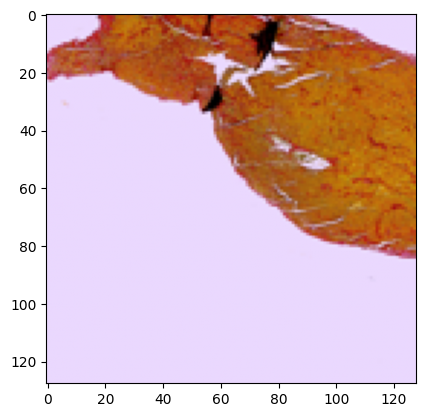

In [16]:
plt.imshow(x_train[0])

## Our CNN approach

In [17]:
def f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [18]:
from keras import metrics
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
model = Sequential()
input_shape = (128, 128, 4)

model.add(Conv2D(filters=128, kernel_size = (3,3), padding = 'valid', activation = 'relu', input_shape = input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())
model.add(Conv2D(filters=16, kernel_size = (3,3), strides =2, padding = 'valid', activation = 'relu'))
model.add(BatchNormalization())

model.add(Dropout(0.2))
model.add(Flatten())

model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.13))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.13))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.13))
model.add(Dense(1, activation="sigmoid"))

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    metrics=[metrics.binary_accuracy,f1_score],
    optimizer = tf.keras.optimizers.Adam(1e-6))

dot_img_file = 'model.png'

In [19]:
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
print(class_weights)

{0: 0.9830917874396136, 1: 1.0175}


## This is where we balance class weights

In [20]:
from sklearn.utils import compute_class_weight
train_classes = Y_train
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train_classes),
                                        y = train_classes                                                    
                                    )
class_weights = dict(zip(np.unique(train_classes), class_weights))
class_weights

{0: 0.9830917874396136, 1: 1.0175}

## Training the model

In [22]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

model.fit(
    x_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_val, y_val),
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1 
)

Epoch 1/100
7/7 [==============================] - 8s 839ms/step - loss: 0.6912 - binary_accuracy: 0.4877 - f1_score: 0.4998 - val_loss: 0.6935 - val_binary_accuracy: 0.4657 - val_f1_score: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 6s 801ms/step - loss: 0.6915 - binary_accuracy: 0.5172 - f1_score: 0.5049 - val_loss: 0.6931 - val_binary_accuracy: 0.5098 - val_f1_score: 0.6308
Epoch 3/100
7/7 [==============================] - 5s 749ms/step - loss: 0.6949 - binary_accuracy: 0.4680 - f1_score: 0.4600 - val_loss: 0.6930 - val_binary_accuracy: 0.5343 - val_f1_score: 0.6577
Epoch 4/100
7/7 [==============================] - 6s 880ms/step - loss: 0.7003 - binary_accuracy: 0.4778 - f1_score: 0.4304 - val_loss: 0.6928 - val_binary_accuracy: 0.5490 - val_f1_score: 0.6799
Epoch 5/100
7/7 [==============================] - 5s 745ms/step - loss: 0.6865 - binary_accuracy: 0.5172 - f1_score: 0.4836 - val_loss: 0.6926 - val_binary_accuracy: 0.5392 - val_f1_score: 0.6779
Epoch 6/100

In [23]:
best_cnn = load_model('/kaggle/working/best_model.h5', custom_objects={"f1_score": f1_score })
best_cnn.evaluate(x_test,y_test)

4/4 [==============================] - 1s 140ms/step - loss: 0.6916 - binary_accuracy: 0.5285 - f1_score: 0.6830


[0.6916105151176453, 0.5284552574157715, 0.6829860806465149]

Text(0.5, 25.722222222222214, 'Actual')

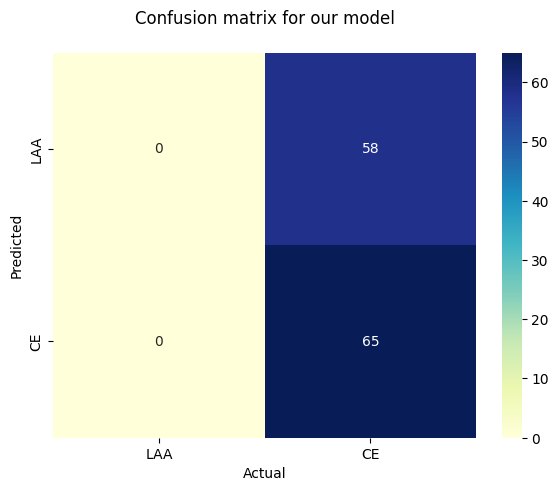

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(15, 5))

preds = best_cnn.predict(x_test)
preds = (preds >= 0.5).astype(np.int32)

cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=['LAA', 'CE'], columns=['LAA', 'CE'])
plt.subplot(121)
plt.title("Confusion matrix for our model\n")
sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu")
plt.ylabel("Predicted")
plt.xlabel("Actual")

## Submission for kaggle competition

In [25]:
test1=[]
for i in test_df['file_path']:
    x1=preprocess(i)
    test1.append(x1)
    print(i)
    
test1=np.array(test1)


../input/mayo-clinic-strip-ai/test/006388_0.tif
../input/mayo-clinic-strip-ai/test/008e5c_0.tif
../input/mayo-clinic-strip-ai/test/00c058_0.tif
../input/mayo-clinic-strip-ai/test/01adc5_0.tif


In [26]:
cnn_pred=model.predict(test1)
cnn_pred

array([[0.0037801 ],
       [0.01543733],
       [0.03616455],
       [0.02557364]], dtype=float32)

In [27]:
sub = pd.DataFrame(test_df["patient_id"].copy())
sub["CE"] = cnn_pred
sub["LAA"] = 1- sub["CE"]

sub = sub.groupby("patient_id").mean()
sub = sub[["CE", "LAA"]].round(6).reset_index()
sub

,patient_id,CE,LAA
0,006388,0.003780,0.996220
1,008e5c,0.015437,0.984563
2,00c058,0.036165,0.963836
3,01adc5,0.025574,0.974426


In [28]:
label_counts = train_df["label"].value_counts()
print(label_counts)

LAA    207
CE     200
Name: label, dtype: int64


In [29]:
sub["prediction"] = sub["CE"].apply(lambda x : "CE" if x>=0.5 else "LAA")
sub["actual"] = ["CE", "CE", "LAA","LAA"]
print(sub)

def weighted_log_loss(y_true, y_pred, weights, N):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    weights = np.array(weights)
    N = np.array(N) 

    log_loss_per_class = -np.sum(y_true / N[:, np.newaxis] * np.log(y_pred), axis=0)

    weighted_log_loss_value = np.sum(weights * log_loss_per_class) / np.sum(weights)
 
    return weighted_log_loss_value

y_true = np.array([[1, 0],
                [1, 0],
                [0, 1],
                [0, 1]])
    
N = [545,545,205,205]

y_pred = np.clip(sub.iloc[:, [1, 2]].values, 1e-15, 1 - 1e-15)

weights = np.array([1,1]) 

log_loss = weighted_log_loss(y_true, y_pred, weights, N)
print("log_loss:",log_loss)



  patient_id        CE       LAA prediction actual
0     006388  0.003780  0.996220        LAA     CE
1     008e5c  0.015437  0.984563        LAA     CE
2     00c058  0.036165  0.963836        LAA    LAA
3     01adc5  0.025574  0.974426        LAA    LAA
log_loss: 0.009097081125257705
